#### Repeat of email. 



1. Generally you would want about 5-10 of each class type. The median number of classes in our dataset is about 2.5, and there are plenty of 1s that can't be used due to the test split nature of ML.
2.  threw away all labels with less than five observations in the set, this can possibly be relaxed to 3-4 with alternative validation procedures.
3. I have calculated results in the form of a confusion matrix and f-1 scores
4. The results obtained can be improved with further optimisation. No optimisation has been done, this is an easy step but only necessary when finalising the model. 
5. I think the out of sample performance is slightly overstated as is.
   
   My reasoning: documents of very similar written structure is exposed both in the training and testing set. It probably overfits, and I would suspect it accounts for about 20% of performance above a random benchmark. 

How to improve the non-ML part:

1. More data in quantity for all applicable labels.

2. Focus on diversity of documents for increased performance.

3. Tighten categories i.e. flatten 2-3 similar categories into 1.

4. Obtain more upstream features for example:

    1. Actual text in documents

        a. Used to calculate lenght.

        b. verbosity.

        c.  polarity

   


How to improve out of sample performance, ML part:

1. Optimisation (2 hours)

2. Further feature engineering (2-4 hours)

3. Cluster document descriptions according to syntax and stratify into different training and testing sets.


Most important I would say is getting more data, and additional upstream features (variables) to use in the prediction process.


Also just one thing to clarify from your previous email:


"Use the [documents] and [class] as an input for train and test data, to write a classifier to predict the tags ( [class] ) " - I suspect that you meant labels for the bolded text and have treated it as such.


Regards,

Derek

In [1]:
import gc
import numpy as np
import pandas as pd
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm
import lightgbm as lgb

df = pd.read_csv("regulation_cleaned.csv")

In [2]:
# ## This splitting can't be done, would have to stratify, large number of classes

# import numpy as np
# #Keeping 15% for the validation set, thats about 1000 instances to test on
# msk = np.random.rand(len(df)) < 0.40
# df["is_test"] = msk

# test = df[df["is_test"]].reset_index()
# train = df[df["is_test"]==False].reset_index()

In [3]:
df["label"] = df["label"].map(str.strip)

In [4]:
df["label"].value_counts().median() ### Much too low, should be around 5-10 

3.0

In [5]:
## Everything with a value count of 1 would have to be removed.
df["label"].value_counts().tail()

public companies                      1
electronic payment (sfi)              1
securities exchanges                  1
private asset management companies    1
asset management company              1
Name: label, dtype: int64

In [7]:
## Makes sure that there is at least five samples per label
count_class = 5
list_two = list(df["label"].value_counts()[df["label"].value_counts()>count_class].index.values)
df = df[df["label"].isin(list_two)].reset_index(drop=True)

In [8]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['label'] = le.fit_transform(df['label'])  

In [9]:
df.head()

,label,documents,class
0,0,Offshore Banking Act,banking
1,0,The Banking Act of The Republic of China,banking
2,0,Cap. 155 Banking Ordinance,banking
3,0,Reserve Bank of New Zealand Act 1989,banking
4,0,Trustee Banks Restructuring Act Repeal Act 1999,banking


In [10]:
from sklearn.model_selection import train_test_split

train, test, y_train, y_test = train_test_split(df.drop(["label"],axis=1), df["label"], test_size=0.4, random_state=0, stratify= df["label"])

In [12]:
print(train.head())
# print(test.head())
print(train.shape, test.shape)


# Extract features
def extract_features(df):
    df['class_len'] = df['class'].apply(lambda x: len(str(x)))
    df['documents_len'] = df['documents'].apply(lambda x: len(str(x)))
    df['class_wc'] = df['class'].apply(lambda x: len(str(x).split(' ')))
    df['documents_wc'] = df['documents'].apply(lambda x: len(str(x).split(' ')))

extract_features(train)
extract_features(test)


df_all = pd.concat([train, test], axis=0)
gc.collect()

                                             documents      class
744                          Concept paper on Istisna’  insurance
369  Notice 612 Credit Files, Grading and Provisioning    banking
588  Insurance (Accounts and Statements) Regulation...  insurance
666  Appointed Actuary: Appointment and Duties (for...  insurance
129                              Transfers of business    banking
(688, 2) (459, 2)


21

In [13]:
df_all.head()

,documents,class,class_len,documents_len,class_wc,documents_wc
744,Concept paper on Istisna’,insurance,9,25,1,4
369,"Notice 612 Credit Files, Grading and Provisioning",banking,7,49,1,7
588,Insurance (Accounts and Statements) Regulation...,insurance,9,52,1,6
666,Appointed Actuary: Appointment and Duties (for...,insurance,9,82,1,10
129,Transfers of business,banking,7,21,1,3


In [14]:
df["documents"].shape

(1147,)

In [15]:
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 7,
    'metric': ['multi_error'],
    "learning_rate": 0.05,
     "num_leaves": 60,
     "max_depth": 9,
     "feature_fraction": 0.45,
     "bagging_fraction": 0.3,
     "reg_alpha": 0.15,
     "reg_lambda": 0.15,
#      "min_split_gain": 0,
      "min_child_weight": 0
                }

In [16]:
# Preprocess text
print('Preprocessing text...')
cols = [
    'class', 
    'documents', 
]
n_features = [
    6, 
    240, 
]

for c_i, c in tqdm(enumerate(cols)):
    tfidf = TfidfVectorizer(
        max_features=n_features[c_i],
        norm='l2',
        )
    tfidf.fit(df_all[c])
    tfidf_train = np.array(tfidf.transform(train[c]).toarray(), dtype=np.float16)
    tfidf_test = np.array(tfidf.transform(test[c]).toarray(), dtype=np.float16)

    for i in range(n_features[c_i]):
        train[c + '_tfidf_' + str(i)] = tfidf_train[:, i]
        test[c + '_tfidf_' + str(i)] = tfidf_test[:, i]
        
    del tfidf, tfidf_train, tfidf_test
    gc.collect()
    
print('Done.')
del df_all
gc.collect()

0it [00:00, ?it/s]

Preprocessing text...


2it [00:00,  6.69it/s]

Done.


0

In [17]:
# Prepare data

cols_to_drop = [
    'class',
    'documents',
    'is_test',
    'label',
    'index'
]
X = train.drop(cols_to_drop, axis=1, errors='ignore').reset_index(drop=True)

y = y_train.reset_index(drop=True)
X_test = test.drop(cols_to_drop, axis=1, errors='ignore').reset_index(drop=True)

In [18]:
## drop is_test

In [19]:
pd.options.display.max_columns = None

In [20]:
X.head()

,class_len,documents_len,class_wc,documents_wc,class_tfidf_0,class_tfidf_1,class_tfidf_2,class_tfidf_3,class_tfidf_4,class_tfidf_5,documents_tfidf_0,documents_tfidf_1,documents_tfidf_2,documents_tfidf_3,documents_tfidf_4,documents_tfidf_5,documents_tfidf_6,documents_tfidf_7,documents_tfidf_8,documents_tfidf_9,documents_tfidf_10,documents_tfidf_11,documents_tfidf_12,documents_tfidf_13,documents_tfidf_14,documents_tfidf_15,documents_tfidf_16,documents_tfidf_17,documents_tfidf_18,documents_tfidf_19,documents_tfidf_20,documents_tfidf_21,documents_tfidf_22,documents_tfidf_23,documents_tfidf_24,documents_tfidf_25,documents_tfidf_26,documents_tfidf_27,documents_tfidf_28,documents_tfidf_29,documents_tfidf_30,documents_tfidf_31,documents_tfidf_32,documents_tfidf_33,documents_tfidf_34,documents_tfidf_35,documents_tfidf_36,documents_tfidf_37,documents_tfidf_38,documents_tfidf_39,documents_tfidf_40,documents_tfidf_41,documents_tfidf_42,documents_tfidf_43,documents_tfidf_44,documents_tfidf_45,documents_tfidf_46,documents_tfidf_47,documents_tfidf_48,documents_tfidf_49,documents_tfidf_50,documents_tfidf_51,documents_tfidf_52,documents_tfidf_53,documents_tfidf_54,documents_tfidf_55,documents_tfidf_56,documents_tfidf_57,documents_tfidf_58,documents_tfidf_59,documents_tfidf_60,documents_tfidf_61,documents_tfidf_62,documents_tfidf_63,documents_tfidf_64,documents_tfidf_65,documents_tfidf_66,documents_tfidf_67,documents_tfidf_68,documents_tfidf_69,documents_tfidf_70,documents_tfidf_71,documents_tfidf_72,documents_tfidf_73,documents_tfidf_74,documents_tfidf_75,documents_tfidf_76,documents_tfidf_77,documents_tfidf_78,documents_tfidf_79,documents_tfidf_80,documents_tfidf_81,documents_tfidf_82,documents_tfidf_83,documents_tfidf_84,documents_tfidf_85,documents_tfidf_86,documents_tfidf_87,documents_tfidf_88,documents_tfidf_89,documents_tfidf_90,documents_tfidf_91,documents_tfidf_92,documents_tfidf_93,documents_tfidf_94,documents_tfidf_95,documents_tfidf_96,documents_tfidf_97,documents_tfidf_98,documents_tfidf_99,documents_tfidf_100,documents_tfidf_101,documents_tfidf_102,documents_tfidf_103,documents_tfidf_104,documents_tfidf_105,documents_tfidf_106,documents_tfidf_107,documents_tfidf_108,documents_tfidf_109,documents_tfidf_110,documents_tfidf_111,documents_tfidf_112,documents_tfidf_113,documents_tfidf_114,documents_tfidf_115,documents_tfidf_116,documents_tfidf_117,documents_tfidf_118,documents_tfidf_119,documents_tfidf_120,documents_tfidf_121,documents_tfidf_122,documents_tfidf_123,documents_tfidf_124,documents_tfidf_125,documents_tfidf_126,documents_tfidf_127,documents_tfidf_128,documents_tfidf_129,documents_tfidf_130,documents_tfidf_131,documents_tfidf_132,documents_tfidf_133,documents_tfidf_134,documents_tfidf_135,documents_tfidf_136,documents_tfidf_137,documents_tfidf_138,documents_tfidf_139,documents_tfidf_140,documents_tfidf_141,documents_tfidf_142,documents_tfidf_143,documents_tfidf_144,documents_tfidf_145,documents_tfidf_146,documents_tfidf_147,documents_tfidf_148,documents_tfidf_149,documents_tfidf_150,documents_tfidf_151,documents_tfidf_152,documents_tfidf_153,documents_tfidf_154,documents_tfidf_155,documents_tfidf_156,documents_tfidf_157,documents_tfidf_158,documents_tfidf_159,documents_tfidf_160,documents_tfidf_161,documents_tfidf_162,documents_tfidf_163,documents_tfidf_164,documents_tfidf_165,documents_tfidf_166,documents_tfidf_167,documents_tfidf_168,documents_tfidf_169,documents_tfidf_170,documents_tfidf_171,documents_tfidf_172,documents_tfidf_173,documents_tfidf_174,documents_tfidf_175,documents_tfidf_176,documents_tfidf_177,documents_tfidf_178,documents_tfidf_179,documents_tfidf_180,documents_tfidf_181,documents_tfidf_182,documents_tfidf_183,documents_tfidf_184,documents_tfidf_185,documents_tfidf_186,documents_tfidf_187,documents_tfidf_188,documents_tfidf_189,documents_tfidf_190,documents_tfidf_191,documents_tfidf_192,documents_tfidf_193,documents_tfidf_194,documents_tfidf_195,documents_tfidf_196,documents_tfidf_197,documents_tfidf_198

In [425]:
print(len(y.unique()), len(y_test.unique()))

25 25


In [426]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support


id_test = test.index.values
feature_names = list(X.columns)
print(X.shape, X_test.shape)

#del train, test
gc.collect()

# Build the model
cnt = 0
p_buf = []
n_splits = 3
n_repeats = 1
kf = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=0)
auc_buf = []   

for train_index, valid_index in kf.split(X):
    print('Fold {}/{}'.format(cnt + 1, n_splits))
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        #'objective': 'multiclassova',
        'num_class': 46, #len(y.unique())
        # 'metric': ['multi_logloss'],
        'metric': ['multi_error'],## this one gave probabilities over all
        'max_depth': 14,
        'num_leaves': 31,
        'learning_rate': 0.025,
        'feature_fraction': 0.85,
        'bagging_fraction': 0.85,
        'bagging_freq': 5,
        'verbose': 0,
        'num_threads': 1,
        'lambda_l2': 1.0,
        'min_gain_to_split': 0,
    }  

    lgb_train = lgb.Dataset(
        X.loc[train_index], 
        y.loc[train_index], 
        feature_name=feature_names,
        )
    lgb_train.raw_data = None

    lgb_valid = lgb.Dataset(
        X.loc[valid_index], 
        y.loc[valid_index],
        )
    lgb_valid.raw_data = None

    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_valid],
        early_stopping_rounds=100,
        verbose_eval=100,
    )

    if cnt == 0:
        importance = model.feature_importance()
        model_fnames = model.feature_name()
        tuples = sorted(zip(model_fnames, importance), key=lambda x: x[1])[::-1]
        tuples = [x for x in tuples if x[1] > 0]
        print('Important features:')
        for i in range(60):
            if i < len(tuples):
                print(tuples[i])
            else:
                break
            
        del importance, model_fnames, tuples

    y_pred = model.predict(X.loc[valid_index], num_iteration=model.best_iteration)
    
    pred_class = [np.argmax(line) for line in y_pred]
    
    #cm = confusion_matrix(y.loc[valid_index], pred_class)
    
    cm = classification_report(y.loc[valid_index], pred_class, target_names=list(le.inverse_transform(y.loc[valid_index].sort_values().unique())))
    print(cm)
    
    report = pd.DataFrame(list(precision_recall_fscore_support(y.loc[valid_index], pred_class)),
                index=['Precision', 'Recall', 'F1-score', 'Support']).T

    # Now add the 'Avg/Total' row
    report.loc['Avg/Total', :] = precision_recall_fscore_support(y.loc[valid_index], pred_class,
        average='weighted')
    report.loc['Avg/Total', 'Support'] = report['Support'].sum()

    p = model.predict(X_test, num_iteration=model.best_iteration)
    if len(p_buf) == 0:
        p_buf = np.array(p, dtype=np.float16)
    else:
        p_buf += np.array(p, dtype=np.float16)

    cnt += 1
    if cnt > 0: # Comment this to run several folds
        break
    
    del model, lgb_train, lgb_valid, p
    gc.collect

preds = p_buf/cnt

preds = [np.argmax(line) for line in preds]

# Prepare submission
subm = pd.DataFrame()
subm['id'] = id_test
subm['label'] = preds
subm.to_csv('submission.csv', index=False)

(688, 250) (459, 250)
Fold 1/3
Training until validation scores don't improve for 100 rounds.
[100]	training's multi_error: 0.187773	valid_1's multi_error: 0.295652
[200]	training's multi_error: 0.113537	valid_1's multi_error: 0.286957
Early stopping, best iteration is:
[151]	training's multi_error: 0.155022	valid_1's multi_error: 0.282609
Important features:
('documents_len', 1758)
('documents_wc', 1092)
('class_tfidf_0', 741)
('documents_tfidf_160', 718)
('class_len', 670)
('documents_tfidf_162', 657)
('documents_tfidf_31', 563)
('documents_tfidf_158', 537)
('documents_tfidf_25', 493)
('class_tfidf_1', 422)
('documents_tfidf_99', 395)
('class_tfidf_4', 380)
('documents_tfidf_228', 377)
('class_tfidf_3', 257)
('documents_tfidf_174', 184)
('documents_tfidf_114', 180)
('documents_tfidf_45', 164)
('documents_tfidf_47', 157)
('documents_tfidf_96', 152)
('documents_tfidf_124', 132)
('class_tfidf_2', 121)
('documents_tfidf_229', 119)
('documents_tfidf_189', 98)
('documents_tfidf_84', 96)
('

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [392]:
list_ind = list(le.inverse_transform(y.loc[valid_index].sort_values().unique()))

list_ind.append("Avg/Total")

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [395]:
report.index = list_ind

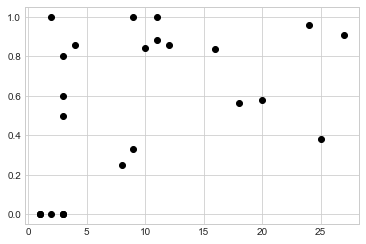

In [402]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np


## Need more labelled instances, here you can see the more support (x-axis) the better performance *y-axis)
x = report["Support"].iloc[:-1]
y = report["F1-score"].iloc[:-1]

plt.plot(x, y, 'o', color='black');


In [406]:
report

,Precision,Recall,F1-score,Support
banking,0.642857,0.500000,0.562500,18.0
banking & islamic banking,0.238095,0.555556,0.333333,9.0
banking and lending,0.250000,0.250000,0.250000,8.0
banking and lending/funds,0.000000,0.000000,0.000000,3.0
banks and financial institutions,1.000000,1.000000,1.000000,11.0
central bank,0.000000,0.000000,0.000000,1.0
central bank act,0.000000,0.000000,0.000000,3.0
commercial banks,0.520000,0.650000,0.577778,20.0
companies,1.000000,1.000000,1.000000,9.0
finance companies,0.785714,1.000000,0.880000,11.0


stop here
____________________________________________________________________________
### All below work are tests and experiments. This should mostly be ignored.

In [368]:
y.loc[valid_index].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

In [369]:
list(le.inverse_transform(y.loc[valid_index].sort_values().unique()))

/Users/dereksnow/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['banking',
 'banking & islamic banking',
 'banking and lending',
 'banking and lending/funds',
 'banks and financial institutions',
 'central bank',
 'central bank act',
 'commercial banks',
 'companies',
 'finance companies',
 'funds',
 'insurance',
 'insurance & takaful',
 'listed companies and corporate financing',
 'merchat banks',
 'non-banking',
 'payment and settlement systems',
 'payment services',
 'payment system',
 'payment system ',
 'payments',
 'securities',
 'securities, futures and fund management',
 'securitisation ',
 'trust companies']

In [ ]:
def getSentFeat(s):
    sent = TextBlob(s).sentiment
    return (sent.polarity, sent.subjectivity)

print('sentimental analysis')
with Pool(4) as p:
    for col in textColumns:
        temp = pl.array(list(p.map(getSentFeat, T[col])))
        T[col+'_pol'] = temp[:,0]
        T[col+'_sub'] = temp[:,1]
        numFeatures += [col+'_pol', col+'_sub']

%%time
# from nltk.stem.wordnet import WordNetLemmatizer
# from autocorrect import spell  # as spell checker and corrector
# L = WordNetLemmatizer()
p = PorterStemmer()
def wordPreProcess(sentence):
    return ' '.join([p.stem(x.lower()) for x in re.split('\W', sentence) if len(x) >= 1])
# return ' '.join([p.stem(L.lemmatize(spell(x.lower()))) for x in re.split('\W', sentence) if len(x) > 1])


def getTextFeatures(T, Col, max_features=10000, ngrams=(1,2), verbose=True):
    if verbose:
        print('processing: ', Col)
    vectorizer = CountVectorizer(stop_words=None,
                                 preprocessor=wordPreProcess,
                                 max_features=max_features,
                                 binary=True,
                                 ngram_range=ngrams)
#     vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'),
#                                  preprocessor=wordPreProcess,
#                                  max_features=max_features)
    X = vectorizer.fit_transform(T[Col])
    return X, vectorizer.get_feature_names()

n_es1, n_es2, n_prs, n_rd, n_pt = 3000, 8000, 2000, 3000, 1000
X_es1, feat_es1 = getTextFeatures(T, 'project_essay_1', max_features=n_es1)
X_es2, feat_es2 = getTextFeatures(T, 'project_essay_2', max_features=n_es2)
X_prs, feat_prs = getTextFeatures(T, 'project_resource_summary', max_features=n_prs)
X_rd, feat_rd = getTextFeatures(T, 'resource_description', max_features=n_rd, ngrams=(1,3))
X_pt, feat_pt = getTextFeatures(T, 'project_title', max_features=n_pt)

X_txt = hstack((X_es1, X_es2, X_prs, X_rd, X_pt))
del X_es1, X_es2, X_prs, X_rd, X_pt

# 
# from sklearn.decomposition import TruncatedSVD
# svd = TruncatedSVD(1000)
# X_txt = svd.fit_transform(X_txt)

### Text Preprocessing

Text preprocessing made on the competition datasets. The preprocessing consists of 4 steps:

    Removing punctuation from titles and contents
    Removing stopwords from titles and contents
    Converting the tags from string to a list of tags

This type of operations can be used as a first step for any other process regarding the competition.


In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import re
import string

In [22]:
df = pd.read_csv("regulation_cleaned.csv")

In [48]:
df.head(20)

,label,documents,class,documents_clean
0,provident fund,provident fund act b e 2530 1987 amended,funds,"[provident, fund, act]"
1,provident fund,provident fund act 2 b e 2542 1999,funds,"[provident, fund, act]"
2,provident fund,provident fund act 3 b e 2550 2007,funds,"[provident, fund, act]"
3,provident fund,provident fund act 4 b e 2558 2015,funds,"[provident, fund, act]"
4,agent banking,guideline appointment operations third party a...,banking,"[appointment, operation, party, agent]"
5,agent banking,guidelines agent banking banking institutions ...,banking,"[guideline, agent, banking, institution]"
6,agent banking,agent banking,banking,"[agent, banking]"
7,agent banking,faqs agent banking,banking,"[agent, banking]"
8,agent banking,guidelines regulation agent banking agent bank...,banking,"[guideline, regulation, agent, banking, agent,..."
9,asset management company,emergency decree asset management company,companies,"[emergency, asset, management, company]"


In [ ]:
import numpy as np
import pandas as pd
import nltk
import re
import string
from nltk.tokenize import word_tokenize
from subprocess import check_output
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

punctuations = string.punctuation

def data_clean(data):
    print('Cleaning data')
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'^\W+|\W+$',' ',x))
    data = data.apply(lambda i: ''.join(i.strip(punctuations))  )
    #print('tokenize')
    data = data.apply(lambda x: word_tokenize(x))

    #Select only the nouns
    is_noun = lambda pos: pos[:2] == 'NN' 
    for i in range(len(data)):
        data[i] = [word for (word, pos) in nltk.pos_tag(data[i]) if is_noun(pos)]
    
    #print('Lemmatizing')
    wordnet_lemmatizer = WordNetLemmatizer()
    data = data.apply(lambda x: [wordnet_lemmatizer.lemmatize(i) for i in x])
    data = data.apply(lambda x: [i for i in x if len(i)>2])
    return(data)

In [34]:
df["documents_clean"] = data_clean(df["documents"])

Cleaning data


In [ ]:
def get_frequency(title):
    
    frequency = []
    inverse_frequency = {}
    for i in range(len(title)):
        word_count = {}

        for word in title[i]:
            if word in word_count:    
                word_count[word] = word_count[word] + 1
            else:
                word_count[word] = 1
                
        for word in word_count:
            if word in inverse_frequency:
                inverse_frequency[word] = inverse_frequency[word] + 1
            else:
                inverse_frequency[word] = 1            
        frequency.append(word_count)
        
    return (frequency, inverse_frequency)



In [36]:
frequency, inverse_frequency = get_frequency(df["documents_clean"])


In [ ]:
import operator
frequency_words = {}
for document in frequency:
    for word in document:
        if word in frequency_words:
            frequency_words[word] = frequency_words[word] + document[word]
        else:
            frequency_words[word] = document[word]            
frequency_words = sorted(frequency_words.values())

In [38]:
print('number of words:',len(frequency_words))

number of words: 779


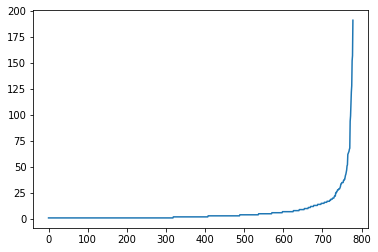

In [39]:
plt.plot(frequency_words)
plt.show()


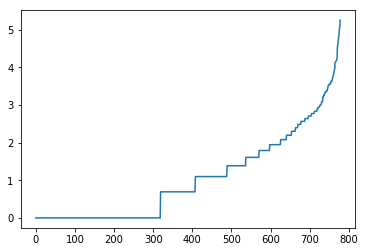

In [40]:
plt.plot(np.log(frequency_words))
plt.show()

In [ ]:
tfidf = frequency

tfidf_distribution = []
for document in tfidf:
    if document == {}:
        continue
    max_frequency = sorted(document.items(), key=operator.itemgetter(1), reverse=True)[0][1]
    for word in document:
        document[word] = document[word]/(max_frequency + 0.0)*np.log(len(tfidf)/(inverse_frequency[word]+0.))
        tfidf_distribution.append(document[word]) 

In [42]:
index = 1
sorted(tfidf[index].items(), key=operator.itemgetter(1), reverse=True)

[('provident', 4.919980925828125),
 ('fund', 3.006331638991033),
 ('act', 2.14047176074377)]

In [43]:
tfidf_distribution = sorted(tfidf_distribution)
print(len(tfidf_distribution))

5204


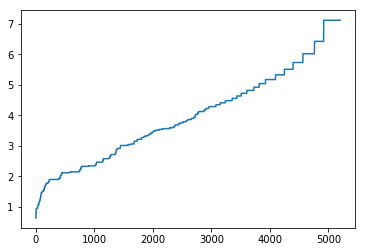

In [44]:
plt.plot(tfidf_distribution)
plt.show()

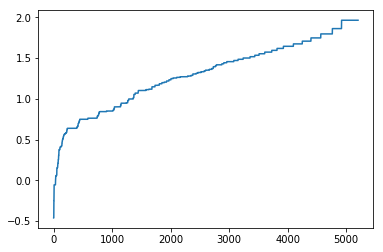

In [45]:
plt.plot(np.log(tfidf_distribution))
plt.show()

In [ ]:
top = 8
output = []
for i in range(0,len(physic)):
    prediction = sorted(tfidf[i], key=tfidf[i].get, reverse=True)[0:top]
    output.append([physic.id[i], ' '.join(prediction)])


In [ ]:
## Older method 

df2 = df.copy()

def removePunctuation(x):
    # Lowercasing all words
    x = x.lower()
    # Removing non ASCII chars
    x = re.sub(r'[^\x00-\x7f]',r' ',x)
    # Removing (replacing with empty spaces actually) all the punctuations
    return re.sub("["+string.punctuation+"]", " ", x)

stops = set(stopwords.words("english"))
def removeStopwords(x):
    # Removing all the stopwords
    filtered_words = [word for word in x.split() if word not in stops]
    return " ".join(filtered_words)

df["label"] = df["label"].map(removePunctuation)
df["documents"] = df["documents"].map(removePunctuation)
df["label"] = df["label"].map(removeStopwords)
df["documents"] = df["documents"].map(removeStopwords)


df.head()